In [1]:
%cd ..

C:\Users\bloic\Desktop\Promutuel_technique


In [2]:
from os.path import join
from config import *

import pandas as pd
import numpy as np
from scipy.stats import gamma, beta

import json
import re
import random

import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import plot
import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

from haversine import haversine, Unit

import warnings
warnings.filterwarnings('ignore')

# Chargement des données

Pour l’**EDA**, nous nous concentrerons sur les données complètes, puisqu’il existe les mêmes données utilisées pour la visualisation.  
Le but dans notre cas étant de faire notre propre visualisation.

In [3]:
df_listings = pd.read_csv(join(DATA_DIR, 'listings_data.csv'))
df_calendar = pd.read_csv(join(DATA_DIR, 'calendar_data.csv'))
df_calendar['date'] = pd.to_datetime(df_calendar['date']) # Format de date pour manipulation

df_neighbourhoods = pd.read_csv(join(DATA_DIR, 'neighbourhoods.csv'))
with open(join(DATA_DIR, 'neighbourhoods.geojson'), mode='r') as f:
    geo = json.load(f)

# Exploratory Data Analysis

Dans ce *notebook*, nous allons pousser l’exploration et l’analyse des données plus loin. Nous visualiserons les données, les liens qu’elles peuvent avoir entre elles, mais aussi dégager des informations qui ne sont pas visibles au travers des chiffres.

# Visualisation de la carte des locations Airbnb de Québec

Ce petit projet me permet également de découvrir la librairie graphique : *plotly*.

## La carte des locations

In [4]:
fig = px.scatter_mapbox(df_listings, lat="latitude", lon="longitude", hover_name="name",
                  color_continuous_scale=px.colors.cyclical.IceFire, size_max=15, zoom=10,
                  mapbox_style="carto-positron")
fig.show()

De ce graphique on dégage que la majorité des locations disponibles se situent au centre ville de Québec ou proche.

## Observation du découpage des quartiers

In [5]:
# Considérons que le coeur du centre ville de Québec est le chateau Frontenac
chateau_frontenac = {"lat": 46.81202203567467, "lon": -71.20546061274469}

In [6]:
fig = px.choropleth_mapbox(df_neighbourhoods, geojson=geo,
                           locations="neighbourhood", featureidkey="properties.neighbourhood",
                           mapbox_style="carto-positron", zoom=9, center=chateau_frontenac)
fig.show()

# Étude des prix

Première **hypothèse** que nous vérifierons en dernier lieu :  
*Plus on s’approche du chateau Frontenac, plus le prix de location est élevé.*

In [7]:
# Commençons par créer une colonne qui va calculer la distance avec le chateau Frontenac
center = tuple(chateau_frontenac.values()) # (lat, lon)
def get_distance(pt1_lat, pt1_lon, pt2):
    return haversine((pt1_lat, pt1_lon), pt2, unit=Unit.METERS)

df_listings['distance_frontenac'] = df_listings.apply(lambda x: get_distance(x['latitude'], x['longitude'], center), axis=1)

**Remarque** : la précision de la mesure de distance n’est pas parfaite puisque nous mesurons la distance à vol d’oiseau.  

$\rightarrow$ Pour la suite, nous essayons de récupérer le prix en date d’aujourd’hui de chacun des logements.

Investiguons les prix selon la distance : 🕵️‍♂️  
1. Calcul de la corrélation.
2. Visualisation de la covariance.

In [8]:
df_listings['price'].isna().sum()

0

Pas de valeur manquante.

In [9]:
df_listings[['distance_frontenac', 'price']]

distance_frontenac    price
0           11363.953242  $100.00
1            6707.586896  $145.00
2            1521.598601  $150.00
3            1158.581018   $83.00
4             453.937135   $40.00
...                  ...      ...
2311         1114.626275   $41.00
2312         1064.654264   $28.00
2313         1116.348234   $44.00
2314         1055.888689   $42.00
2315         1172.945875   $41.00

[2316 rows x 2 columns]

Le prix est une chaîne de caractères. Cependant il est possible d’avoir une virgule et un dollar qui empêchent donc la conversion en float.  
Utilisons une *regex*.

In [10]:
regex = re.compile('[$,]')
df_listings['price'] = df_listings['price'].apply(lambda x: regex.sub('', x)).astype(np.float)

In [11]:
# Vérification NaN
df_listings['price'].isna().sum()

0

## Distribution des prix

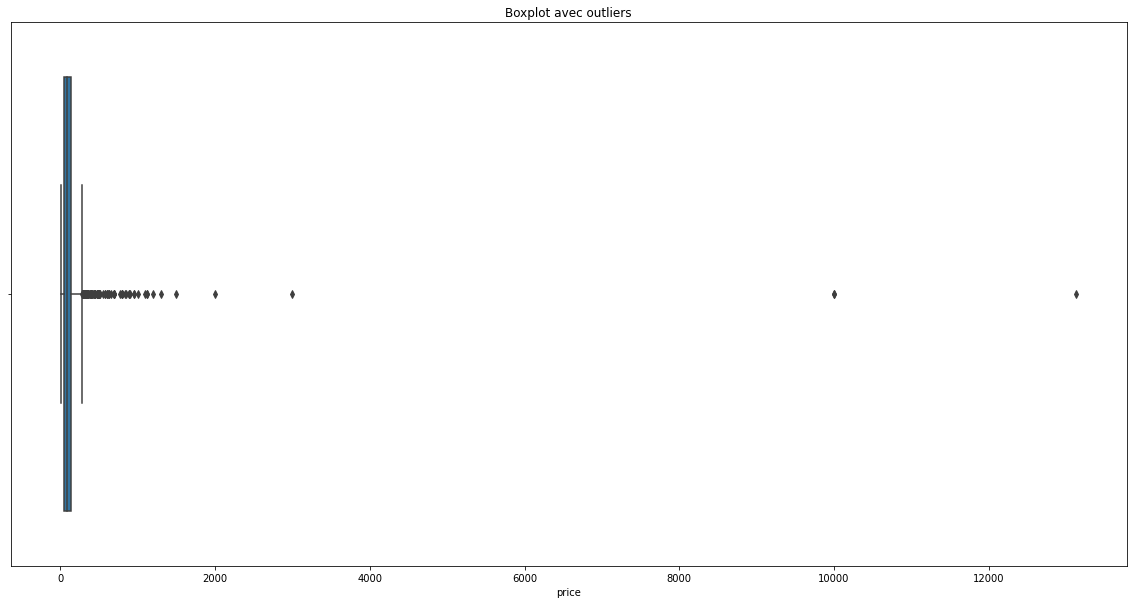

In [12]:
plt.figure(figsize=(20, 10))
ax = sns.boxplot(data=df_listings, x='price')
ax.set_title('Boxplot avec outliers')
plt.show()

**Sans outlier**

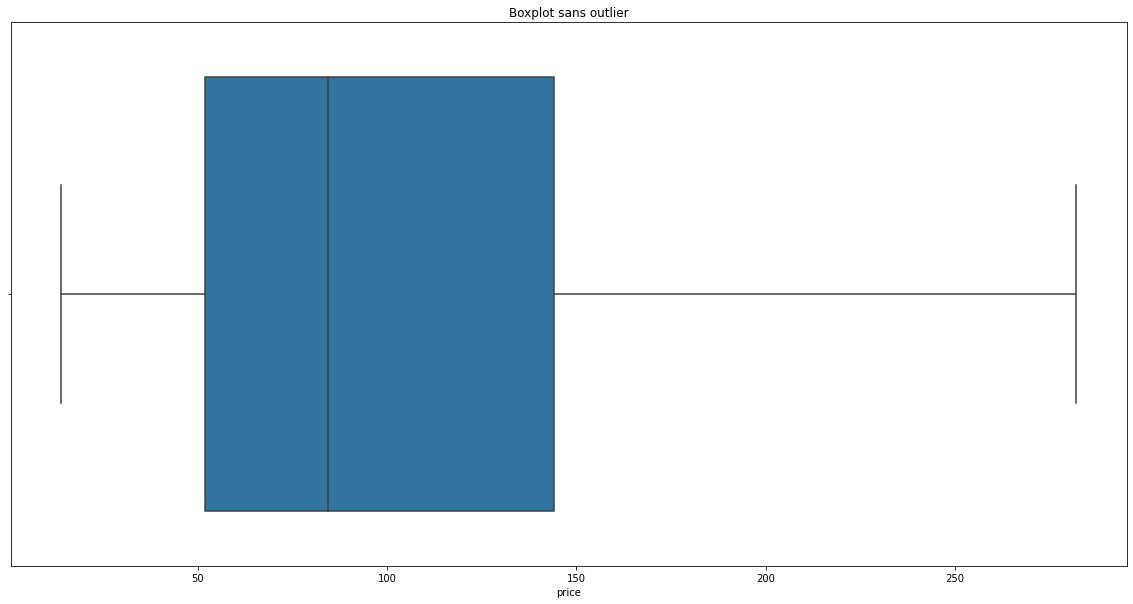

In [13]:
plt.figure(figsize=(20, 10))
ax = sns.boxplot(data=df_listings, x='price', showfliers=False)
ax.set_title('Boxplot sans outlier')
plt.show()

Il existe quelques outliers qui ne nous intéresse pas dans cette visualisation des prix.  
Filtrons les prix > 2000$.

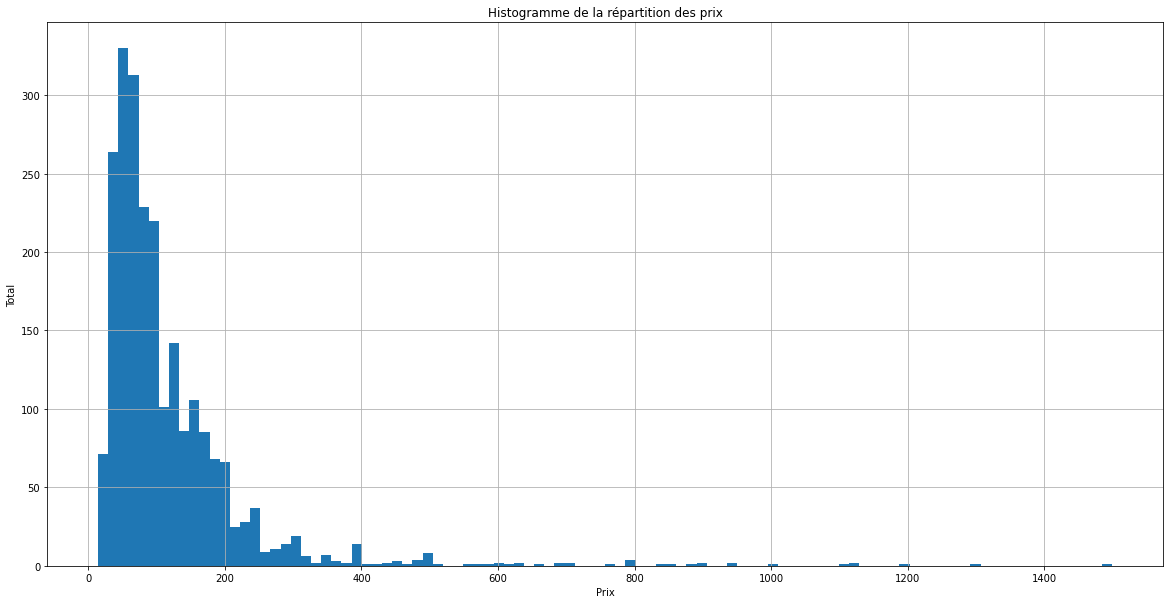

In [14]:
df_price = df_listings[df_listings['price'] < 2000][['distance_frontenac', 'price']]

plt.figure(figsize=(20, 10))
ax = df_price['price'].hist(bins=100)
ax.set_xlabel('Prix')
ax.set_ylabel('Total')
ax.set_title('Histogramme de la répartition des prix')
plt.show()

**Remarque** : Les prix ont une distribution assimilable à une distribution *Gamma*.

Tentons de retrouver les paramètres $\alpha$ et $\beta$ de la distribution *Gamma* :  
Notons $\mu$ la moyenne et $\sigma$ l’écart-type.  
$\mu = \frac{\alpha}{\beta}$ et $\sigma^2 = \frac{\alpha}{\beta^2}$ $\Rightarrow$ $\alpha = \frac{\mu^2}{\sigma^2}$ et $\beta = \frac{\mu}{\sigma^2}$

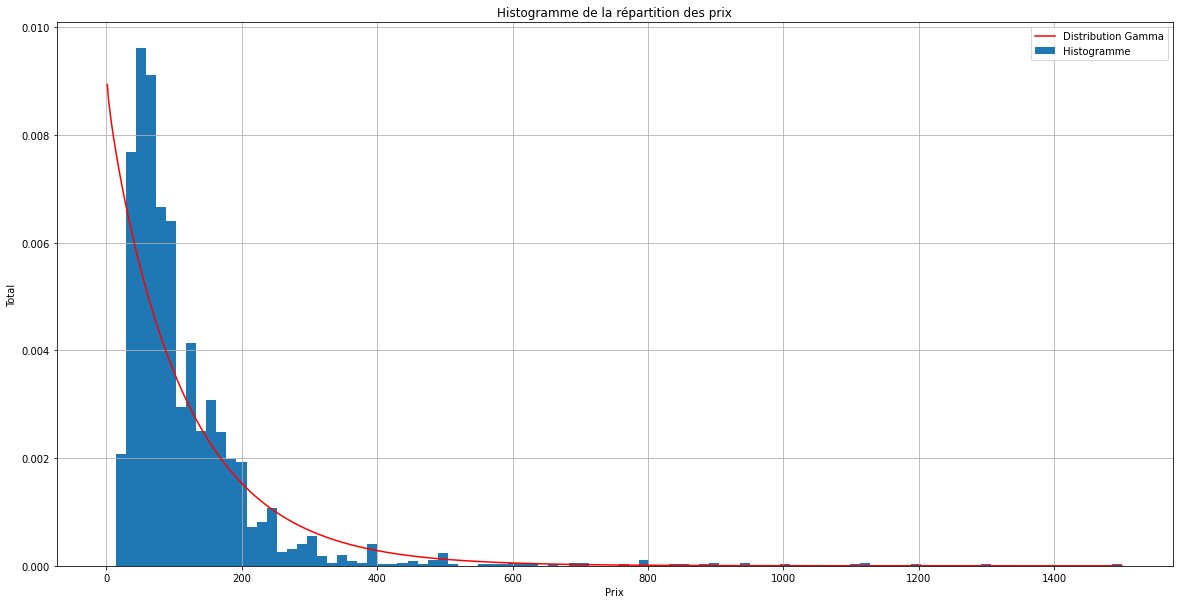

In [15]:
mean = df_price['price'].mean()
var = df_price['price'].var()

a = pow(mean, 2) / var
b = mean / var

x = np.linspace(0, df_price['price'].max(), 1000)

plt.figure(figsize=(20, 10))
ax = df_price['price'].hist(bins=100, label='Histogramme', density=True)
ax.set_xlabel('Prix')
ax.set_ylabel('Total')
ax.set_title('Histogramme de la répartition des prix')
ax.plot(x, gamma.pdf(x, a=a, scale=1/b), c='r', label='Distribution Gamma')
ax.legend()
plt.show()

Pour le calcul de corrélation et la visualisation, reprenons les données avec outliers.m

In [16]:
df_listings[['distance_frontenac', 'price']].corr()

distance_frontenac    price
distance_frontenac             1.00000  0.01737
price                          0.01737  1.00000

Sans :

In [17]:
df_price.corr()

distance_frontenac     price
distance_frontenac            1.000000 -0.067423
price                        -0.067423  1.000000

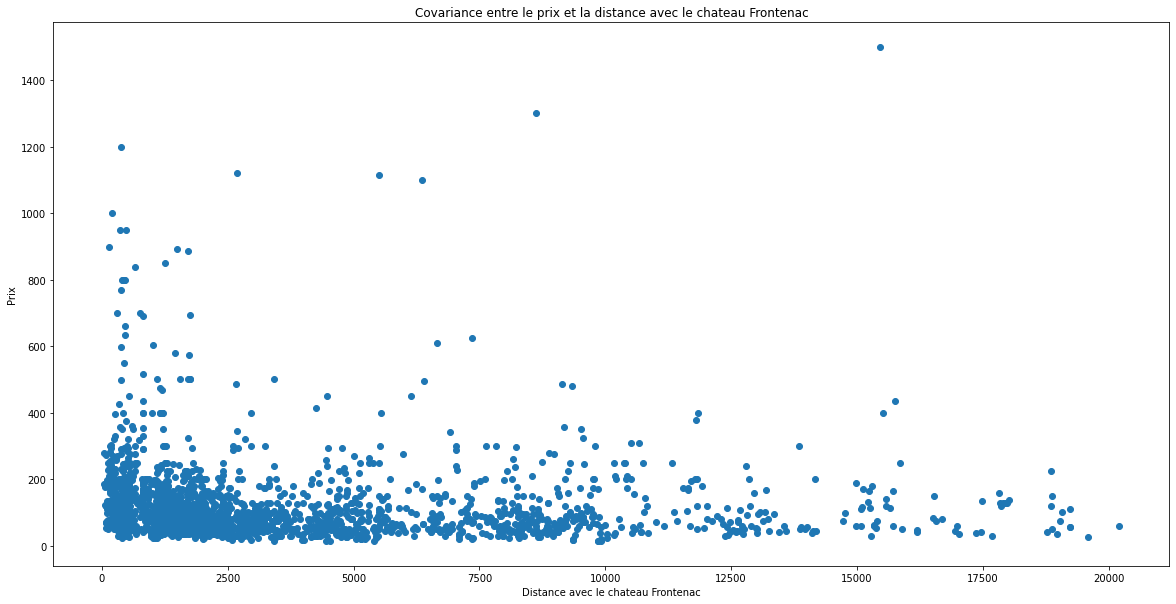

In [18]:
plt.figure(figsize=(20, 10))
plt.scatter(df_price['distance_frontenac'], df_price['price'])
plt.title('Covariance entre le prix et la distance avec le chateau Frontenac')
plt.xlabel('Distance avec le chateau Frontenac')
plt.ylabel('Prix')
plt.show()

$\Rightarrow$ Contrairement à ce que l’on pensait, la distance avec le chateau Frontenac, et par conséquent du centre ville, n’a pas d’impact direct sur le prix.

## Évolution des prix des locations dans le temps

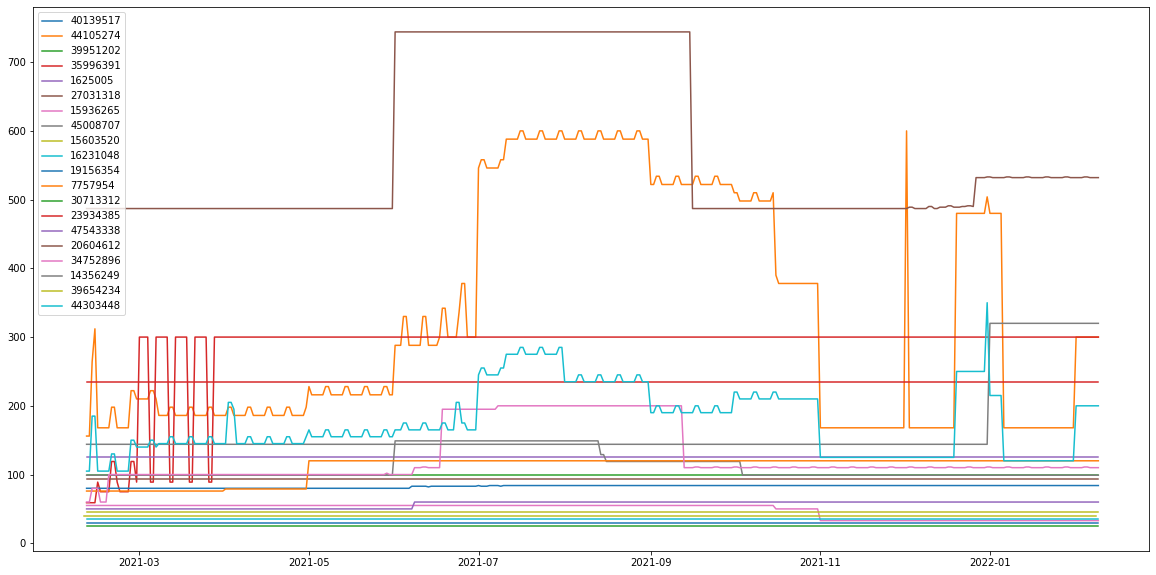

In [19]:
df_calendar['price'] = df_calendar['price'].apply(lambda x: regex.sub('', x)).astype(np.float)

loc_group = df_calendar.groupby('listing_id')

all_ids = list(loc_group.groups.keys())
choices = random.sample(all_ids, 20)

plt.figure(figsize=(20, 10))
for ch in choices:
    df_id = loc_group.get_group(ch)
    plt.plot_date(df_id['date'], df_id['price'], marker=None, linestyle='solid', label=f'{ch}')
plt.legend()
plt.show()

On peut remarquer, que pendant la période d’été, la plupart des prix sont plus élevés.  
On remarque assez souvent de fortes variations périodiques $\Rightarrow$ nous pouvons considérer certains prix de location comme étant stationnaires sur certaines périodes.

In [20]:
df_calendar['date'].min(), df_calendar['date'].max()

(Timestamp('2021-02-09 00:00:00'), Timestamp('2022-02-10 00:00:00'))

## Quel est la moyenne des prix des location entre Juillet et Septembre 2021 ?

In [21]:
# Périodes hors Juillet -> Septembre
start_date = pd.to_datetime(f'2021-07-01') # À modifier si nécassaire
end_date = pd.to_datetime(f'2021-09-01')

cond_date = ~((df_calendar['date'] >= start_date) & (df_calendar['date'] < end_date))
mean_oid = df_calendar[cond_date].groupby('listing_id')['price'].mean() # Mean Out
mean_oid

listing_id
54334       100.000000
138381      145.000000
198548      150.000000
214967       82.838284
268812       40.000000
               ...    
48088050     46.834983
48088182     36.026403
48088287     49.788779
48088350     46.947195
48088429     46.871287
Name: price, Length: 2316, dtype: float64

In [22]:
# Période de Juillet à Septembre
cond_date = (df_calendar['date'] >= start_date) & (df_calendar['date'] < end_date)
mean_iid = df_calendar[cond_date].groupby('listing_id')['price'].mean()  # Mean In
mean_iid

listing_id
54334       100.000000
138381      145.000000
198548      150.000000
214967       82.903226
268812       40.000000
               ...    
48088050     47.000000
48088182     36.000000
48088287     50.000000
48088350     47.000000
48088429     47.000000
Name: price, Length: 2316, dtype: float64

In [23]:
(mean_iid - mean_oid).mean()

19.788012312847535

L’augmentation moyenne durant la période de vacances d’été est d’environ 20$ par nuit, ce qui n’est pas négligeable.

Qu’en est-il de la répartition des augmentations ?

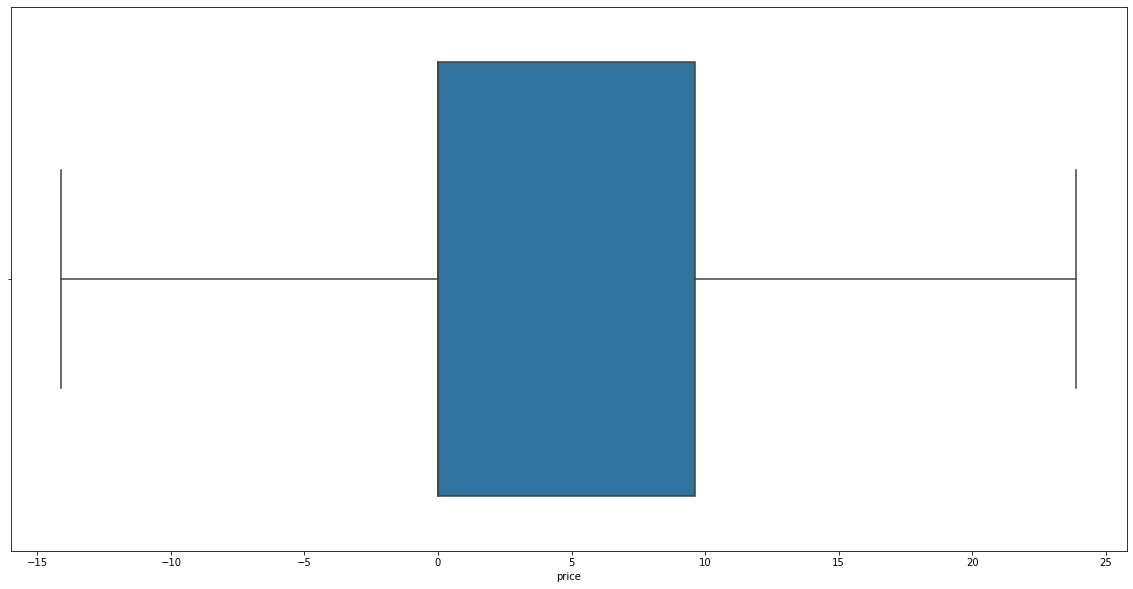

In [24]:
plt.figure(figsize=(20, 10))
sns.boxplot(x=(mean_iid - mean_oid), showfliers=False)
plt.show()

In [25]:
(mean_iid - mean_oid).min(), (mean_iid - mean_oid).max()

(-1441.3960396039604, 388.05940594059405)

Nous avons aussi des réductions de prix en été, dont un logement qui voit se prix être fortement réduit de plus de 1000$.

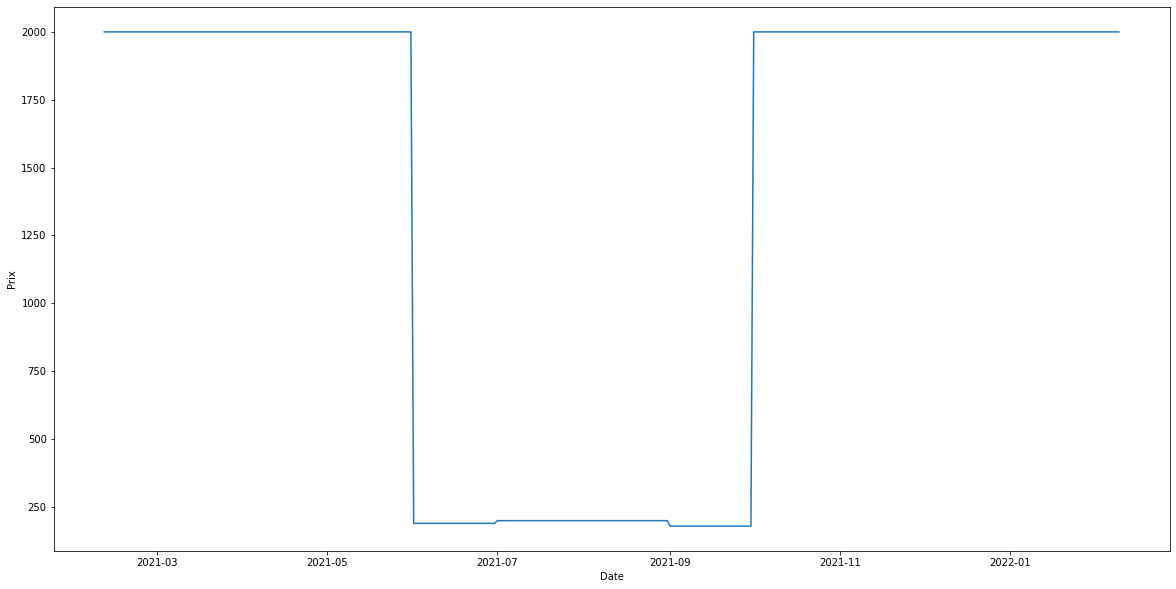

In [26]:
id_min = (mean_iid - mean_oid).idxmin()

plt.figure(figsize=(20, 10))
plt.plot_date(df_calendar[df_calendar['listing_id']==id_min]['date'], df_calendar[df_calendar['listing_id']==id_min]['price'], marker=None, linestyle='solid')
plt.xlabel('Date')
plt.ylabel('Prix')
plt.show()

Étonnament, il y a bien une chute de prix d’une location durant la période d’été.

# Étude générale des corrélations entre variables

In [27]:
# Sélection de features intéressantes
num_cols = ~(df_listings.dtypes == 'object')
num_cols = num_cols[num_cols].index.to_list()
features = []
# On enlève les IDs
for col in num_cols:
    if 'id' not in col:
        features.append(col)
df_listings[features].dtypes

host_listings_count                               int64
host_total_listings_count                         int64
neighbourhood_group_cleansed                    float64
latitude                                        float64
longitude                                       float64
accommodates                                      int64
bathrooms                                       float64
bedrooms                                        float64
beds                                            float64
price                                           float64
minimum_nights                                    int64
maximum_nights                                    int64
minimum_minimum_nights                            int64
maximum_minimum_nights                            int64
minimum_maximum_nights                            int64
maximum_maximum_nights                            int64
minimum_nights_avg_ntm                          float64
maximum_nights_avg_ntm                          

Excellent 👌, on ne garde que les variables numériques. Les IDs sont également exclus de la liste.

In [28]:
df_listings[features].isna().sum()

host_listings_count                                0
host_total_listings_count                          0
neighbourhood_group_cleansed                    2316
latitude                                           0
longitude                                          0
accommodates                                       0
bathrooms                                       2316
bedrooms                                         319
beds                                              14
price                                              0
minimum_nights                                     0
maximum_nights                                     0
minimum_minimum_nights                             0
maximum_minimum_nights                             0
minimum_maximum_nights                             0
maximum_maximum_nights                             0
minimum_nights_avg_ntm                             0
maximum_nights_avg_ntm                             0
calendar_updated                              

Contrôle des valeurs manquantes ? Il en reste pas mal beaucoup, dont certaines colonnes qui sont full NaN que l’on peut supprimner.

In [29]:
features.remove('license')
features.remove('calendar_updated')
features.remove('bathrooms')
features.remove('neighbourhood_group_cleansed')

In [30]:
plt.figure(figsize=(40, 40))
df_listings[features].corr().iplot(kind='heatmap', colorscale="Reds", title="Feature Correlation Matrix")
plt.show()

<Figure size 2880x2880 with 0 Axes>

La matrice de corrélations nous indique que seules les variables groupées par thématiques (reviews, divers comptes de pièces, les disponibilités, etc..) sont corrélées.

# Disponibilités en date d’aujourd’hui

In [31]:
df_calendar.isna().sum()

listing_id        0
date              0
available         0
price             0
adjusted_price    0
minimum_nights    0
maximum_nights    0
dtype: int64

In [32]:
df_calendar.groupby('listing_id')['date'].max().value_counts()

2022-02-09    2112
2022-02-08     203
2022-02-10       1
Name: date, dtype: int64

In [33]:
today = pd.Timestamp.today().floor('D')
df_today = df_calendar[df_calendar['date'] == today]
df_today

listing_id       date available  price adjusted_price  minimum_nights  \
84           54334 2021-05-04         t  100.0        $100.00               2   
449         138381 2021-05-04         t  145.0        $145.00               1   
856        5160965 2021-05-04         t   50.0         $50.00              32   
1221       5442064 2021-05-04         f  330.0        $330.00               3   
1586       5442258 2021-05-04         f  330.0        $330.00               3   
...            ...        ...       ...    ...            ...             ...   
843599    48014282 2021-05-04         t   50.0         $50.00              30   
843964    48039522 2021-05-04         t   50.0         $50.00              30   
844300    46563043 2021-05-04         t  125.0        $125.00               1   
844483    48042841 2021-05-04         t   37.0         $37.00              10   
845058    46580838 2021-05-04         t   20.0         $20.00              31   

        maximum_nights  
84                 180  
449                365  
856               1125  
1221              1125  
1586              1125  
...                ...  
843599             365  
843964            1125  
844300              31  
844483            1125  
845058            1125  

[2316 rows x 7 columns]

Excellent 👍  
Nous pouvons nous amuser à savoir combien de logements sont disponibles aujourd’hui !  

In [34]:
df_today['available'].value_counts()

t    1441
f     875
Name: available, dtype: int64

# La distance par rapport au chateau Frontenac

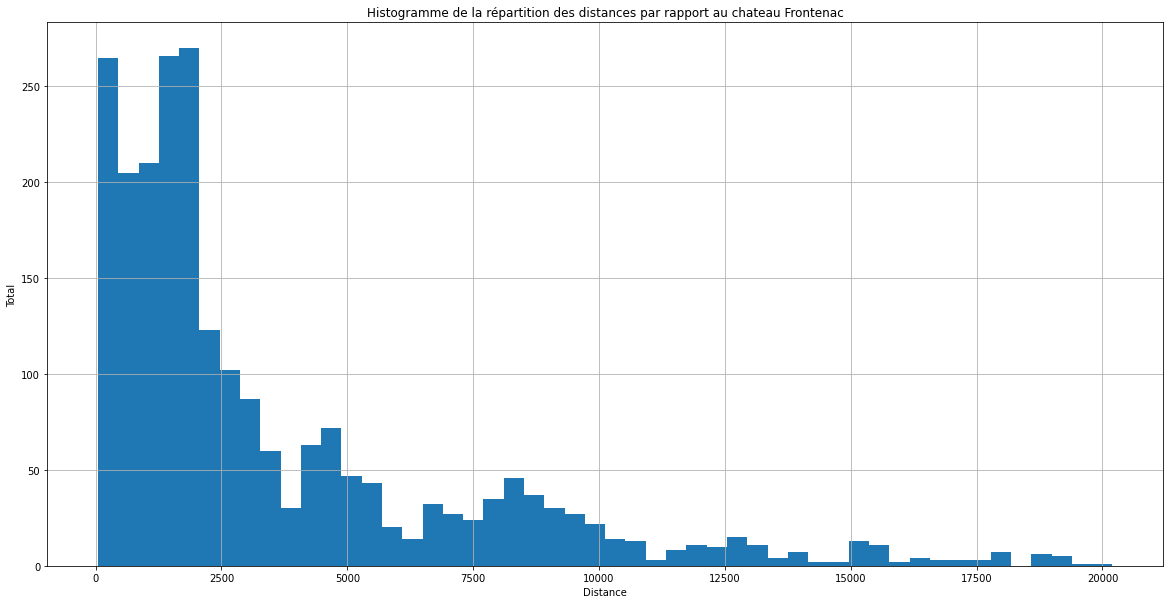

In [35]:
plt.figure(figsize=(20, 10))

df_listings['distance_frontenac'].hist(bins=50)
plt.title('Histogramme de la répartition des distances par rapport au chateau Frontenac')
plt.xlabel('Distance')
plt.ylabel('Total')
plt.show()

Comme nous le pensions, la majorité des locations se situent à proximité du centre ville.

# Les reviews

In [36]:
review_cols = []
for col in df_listings.columns.to_list():
    if 'review' in col:
        review_cols.append(col)
        
df_listings[review_cols].isna().sum()

number_of_reviews                0
number_of_reviews_ltm            0
number_of_reviews_l30d           0
first_review                   408
last_review                    408
review_scores_rating           423
review_scores_accuracy         423
review_scores_cleanliness      423
review_scores_checkin          423
review_scores_communication    423
review_scores_location         423
review_scores_value            423
reviews_per_month              408
dtype: int64

1/6 des valeurs sont manquantes pour la plupart des colonnes.

In [37]:
df_listings['number_of_reviews'].value_counts()

0      408
1      185
2      116
3      101
4       91
      ... 
272      1
266      1
264      1
260      1
589      1
Name: number_of_reviews, Length: 247, dtype: int64

Il y a fort à parier que les 408 logements qui ne possèdent pas de reviews sont également ceux qui n’ont pas de valeurs attribuées pour les colonnes *first_review* et *last_review*.

In [38]:
df_listings[df_listings['number_of_reviews'] > 0][review_cols].isna().sum()

number_of_reviews               0
number_of_reviews_ltm           0
number_of_reviews_l30d          0
first_review                    0
last_review                     0
review_scores_rating           15
review_scores_accuracy         15
review_scores_cleanliness      15
review_scores_checkin          15
review_scores_communication    15
review_scores_location         15
review_scores_value            15
reviews_per_month               0
dtype: int64

Génial 😄, néanmoins pour les catégories de reviews, 15 logements qui ont des notes ne possèdent pas de review par catégorie.  
Est-ce que si nous nous débarassons des données manquantes d’une catégorie, cela enlève également toutes les autres valeurs manquantes ? 🤔

In [39]:
df_listings[df_listings['number_of_reviews'] > 0][review_cols].dropna(subset=['review_scores_rating']).isna().sum()

number_of_reviews              0
number_of_reviews_ltm          0
number_of_reviews_l30d         0
first_review                   0
last_review                    0
review_scores_rating           0
review_scores_accuracy         0
review_scores_cleanliness      0
review_scores_checkin          0
review_scores_communication    0
review_scores_location         0
review_scores_value            0
reviews_per_month              0
dtype: int64

La réponse à la question précédente est **oui** ✅.

In [40]:
df_reviews = df_listings[df_listings['number_of_reviews'] > 0].dropna(subset=['review_scores_rating'])

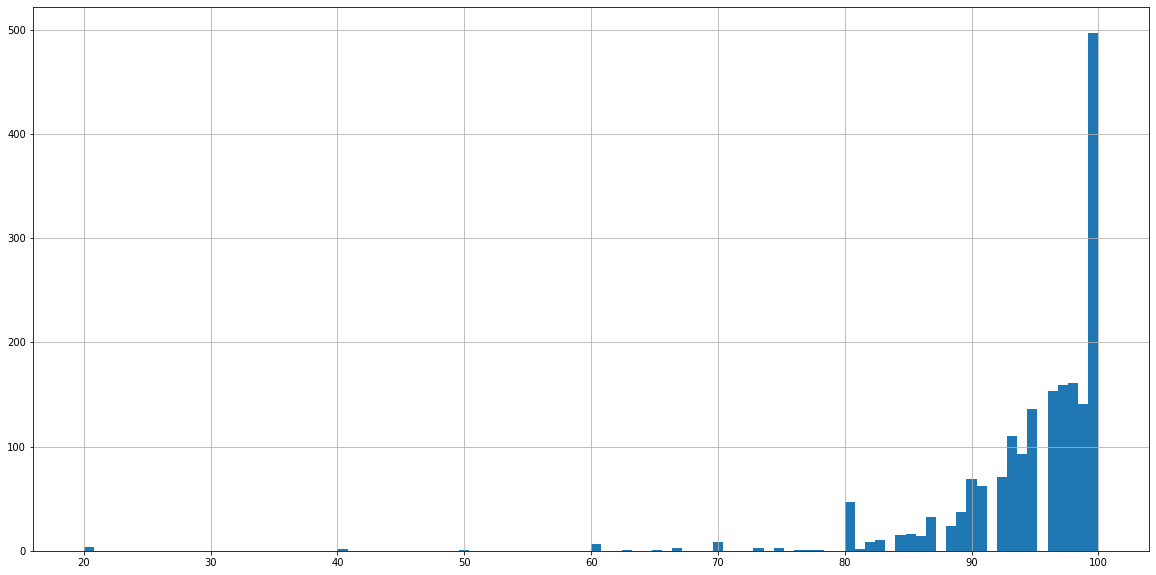

In [41]:
plt.figure(figsize=(20, 10))

df_reviews['review_scores_rating'].hist(bins=100)
plt.show()

Les notes sont pour la plupart situés entre 80 et 100%.  
Nous pouvons tracer chacun des histogrammes en une seule fois.

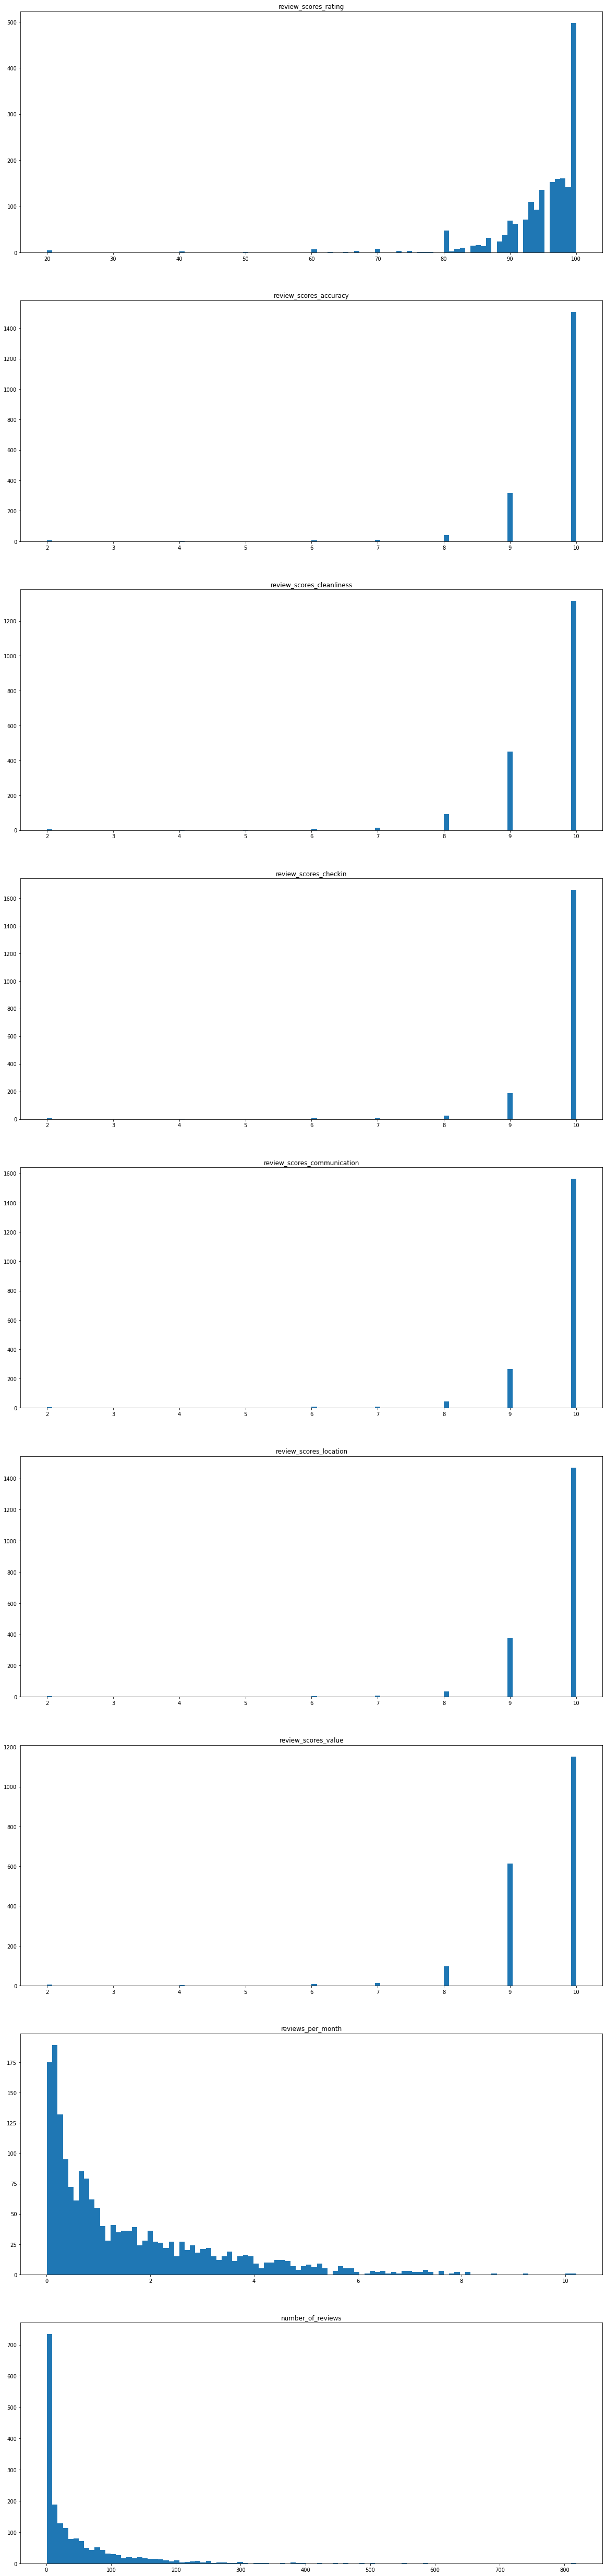

In [42]:
sub_cols = review_cols[5:] + [review_cols[0]]

fig, axs = plt.subplots(len(sub_cols), 1, figsize=(20, 10*len(sub_cols)))

cnt = 0
for cnt, col in enumerate(sub_cols):
    axs[cnt].hist(df_reviews[col], bins=100)
    axs[cnt].set_title(f'{col}')
    
plt.show()

En majorité, les notes sont élevées, ramenées à 100%, elles sont pour la plupart plus élevées que 80%, quelque soit la catégorie.  
De plus, on note qu’il y a très peu de reviews pour la plupart des logements en location.